In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn import metrics
import tqdm
import pickle as pkl

In [2]:
df = pd.read_csv('data/qm8.csv')

In [3]:
df.head()

,smiles,E1-CC2,E2-CC2,f1-CC2,f2-CC2,E1-PBE0,E2-PBE0,f1-PBE0,f2-PBE0,E1-PBE0.1,E2-PBE0.1,f1-PBE0.1,f2-PBE0.1,E1-CAM,E2-CAM,f1-CAM,f2-CAM
0,[H]C([H])([H])[H],0.432952,0.432960,0.249728,0.249736,0.430218,0.430236,0.181436,1.815015e-01,0.430218,0.430236,0.181436,1.815015e-01,0.409931,0.409939,0.1832,0.1832
1,[H]N([H])[H],0.265220,0.350081,0.067015,0.030049,0.268386,0.349106,0.040761,3.164115e-02,0.268386,0.349106,0.040761,3.164115e-02,0.253853,0.334481,0.0575,0.0238
2,[H]O[H],0.286537,0.363579,0.037755,0.000000,0.291377,0.362091,0.019503,1.000000e-08,0.291377,0.362091,0.019503,1.000000e-08,0.278519,0.350074,0.0333,0.0000
3,[H]C#C[H],0.358629,0.358629,0.000000,0.000000,0.256321,0.268469,0.000000,0.000000e+00,0.256321,0.268469,0.000000,0.000000e+00,0.244879,0.255051,0.0000,0.0000
4,[H]C#N,0.319958,0.336074,0.000000,0.000000,0.295139,0.311657,0.000000,0.000000e+00,0.295139,0.311657,0.000000,0.000000e+00,0.283425,0.296993,0.0000,0.0000


In [ ]:
tqdm.tqdm.pandas()

In [11]:
def process_smile(smile):
    mol = Chem.MolFromSmiles(smile)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    
    is_3d = False
    pos = []
    for c in mol.GetConformers():
        pos.append(c.GetPositions())
        is_3d |= c.Is3D()
        
    return np.concatenate(pos)

In [49]:
def smile_features(smile):
    mol = Chem.MolFromSmiles(smile)
    mol = Chem.AddHs(mol)
    
    atomic_nums = [a.GetAtomicNum() for a in mol.GetAtoms()]
    
    dist_matrix = Chem.rdDistGeom.GetMoleculeBoundsMatrix(mol)
    return (atomic_nums, dist_matrix)

In [30]:
mol = Chem.MolFromSmiles(df.smiles[1])
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)

0

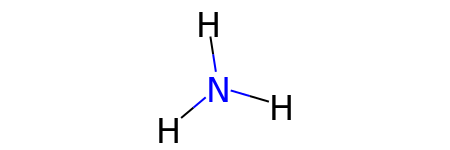

In [31]:
mol

In [66]:
sample_df = df.head(100).copy()

In [36]:
res = df.smiles.head(10).progress_apply(smile_features).to_list()

100%|██████████| 10/10 [00:00<00:00, 674.81it/s]


In [67]:
sample_df.loc[:, ['Z', 'D']] = sample_df.smiles.progress_apply(smile_features).to_list()

100%|██████████| 100/100 [00:00<00:00, 1388.97it/s]


In [68]:
sample_df.to_pickle('data/preprocessed_df.pkl')

In [5]:
sample_df = pd.read_pickle('data/preprocessed_df.pkl')

In [8]:
import data
from torch.utils.data import DataLoader

In [9]:
d = data.QM8Dataset(sample_df.columns[3], 30)

In [10]:
dl = DataLoader(d, 20)

In [11]:
Zs, Ds, sizes, target = next(iter(dl))

In [12]:
sample_df.columns

Index(['smiles', 'E1-CC2', 'E2-CC2', 'f1-CC2', 'f2-CC2', 'E1-PBE0', 'E2-PBE0',
       'f1-PBE0', 'f2-PBE0', 'E1-PBE0.1', 'E2-PBE0.1', 'f1-PBE0.1',
       'f2-PBE0.1', 'E1-CAM', 'E2-CAM', 'f1-CAM', 'f2-CAM', 'Z', 'D'],
      dtype='object')